## Performance study using a spherical molecule

In this section, we investigate bempp-cl's software performance using a spherical molecule.
We ran this experiment on a single CPU node of Pegasus, and the raw result files are located at `/repro-pack/runs/sphere_performance`.
This notebook demonstrates how we generated all results presented in section 3.4.

The sphere has a radius of 1; 100 charges are placed randomly inside, representing the atoms in the solute.
We used the same dielectric constants and salt concentration as in previous the grid-convergence study.
Other simulation parameters are reported in the table below.

#### Table: simulation parameters for performance study for a spherical molecule
| tolerance | # regular quadrature points | FMM expansion order | FMM ncrit |
|:---------:|:------------------------:|:-------------------:|:---------:|
|    1e-4   |             6            |          5          |    500    |

To cover a wide range of problem sizes, we used five surface discretizations, with the number of elements ranging from 8 thousand to 2 million.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from bempp_pbs.postprocess import PLOT_PARAMS, get_df
from matplotlib.pyplot import cycler
import seaborn as sns

In [2]:
plt.rcParams.update(PLOT_PARAMS)   # update plot style
pal = sns.color_palette('colorblind')
pal.as_hex()
cb = cycler(color=pal.as_hex())

**load results**

Similar to the mesh-refinement studies, we obtained three sets of results:
- `direct`: direct formulation with a block-diagonal preconditioner
- `derivative`: derivative formulation with a mass-lumping preconditioner
- `derivative_mass_matrix`: derivative formulation with a mass-matrix preconditioner

In [3]:
direct_df = get_df('../runs/sphere_performance/direct/', formulation='direct', skip4=True)
direct_df

,t_total_assembly,t_total_gmres,num_iter,e_solv [kcal/Mol],memory [GB],t_fmm_init,t_singular_assembler,t_assemble_sparse,t_assembly_other,t_singular_correction,t_laplace,t_helmholtz,t_avg_laplace,t_avg_helmholtz,t_gmres_other
num_elem,,,,,,,,,,,,,,,
8192,5.350415,8.637709,20,-89673.355447,0.918076,0.410753,0.619783,1.46829,2.851589,3.174831,1.030688,4.082883,0.011203,0.044379,0.349308
32768,11.713110,23.430413,24,-89638.782213,1.204908,0.993425,2.750797,1.55875,6.410138,8.522247,3.116694,10.625419,0.028858,0.098384,1.166052
131072,32.784622,111.352906,34,-89628.742308,2.609728,3.656629,6.087689,1.82480,21.215505,30.643350,19.310766,54.413202,0.130478,0.367657,6.985587
524288,121.554657,554.199682,51,-89626.526734,8.978312,13.685470,23.891024,2.74430,81.233863,90.947732,118.413054,311.829986,0.548209,1.443657,33.008909
2097152,483.275211,2676.532763,70,-89626.222002,35.717484,60.712353,94.590553,6.52900,321.443305,295.389086,612.572674,1562.914532,2.097852,5.352447,205.656471


In [4]:
derivative_df = get_df('../runs/sphere_performance/derivative_ex', formulation='derivative', skip4=True)
derivative_df

,t_total_assembly,t_total_gmres,num_iter,e_solv [kcal/Mol],memory [GB],t_fmm_init,t_singular_assembler,t_assemble_sparse,t_assembly_other,t_singular_correction,t_laplace,t_helmholtz,t_avg_laplace,t_avg_helmholtz,t_gmres_other
num_elem,,,,,,,,,,,,,,,
8192,9.594202,6.516131,5,-89672.422047,0.959908,0.429724,0.777763,2.82669,5.560025,2.170241,0.613389,3.421185,0.010953,0.044431,0.311316
32768,22.189271,13.292732,4,-89636.672162,1.388896,1.078442,3.648022,2.92320,14.539608,4.522781,1.341953,6.421103,0.027957,0.097289,1.006896
131072,67.169429,47.477528,4,-89627.601468,3.434748,3.534372,8.569924,3.84650,51.218632,12.609335,6.389493,24.686739,0.133114,0.374041,3.791961
524288,256.326068,165.039098,4,-89625.062292,11.180124,14.912412,33.309138,7.66200,200.442518,25.798528,27.952295,96.317460,0.582339,1.459355,14.970815
2097152,1011.607981,580.525045,4,-89624.051345,42.965260,61.466376,132.445686,22.79500,794.900919,62.593630,104.996047,353.331833,2.187418,5.353513,59.603534


In [5]:
derivative_mass_matrix_df = get_df('../runs/sphere_performance/derivative_ex_mass_matrix/', formulation='derivative', skip4=True)
derivative_mass_matrix_df

,t_total_assembly,t_total_gmres,num_iter,e_solv [kcal/Mol],memory [GB],t_fmm_init,t_singular_assembler,t_assemble_sparse,t_assembly_other,t_singular_correction,t_laplace,t_helmholtz,t_avg_laplace,t_avg_helmholtz,t_gmres_other
num_elem,,,,,,,,,,,,,,,
8192,9.412967,5.769117,4,-89672.365234,0.967952,0.404436,0.775586,2.70066,5.532285,2.028982,0.519315,2.974801,0.010819,0.045073,0.246018
32768,22.451103,14.284596,4,-89636.624671,1.504436,1.098586,3.789467,2.88800,14.675050,5.521132,1.324200,6.493468,0.027587,0.098386,0.945797
131072,68.594301,48.268119,4,-89627.589999,3.616500,3.675576,8.660508,3.90580,52.352417,12.311198,6.111173,24.608536,0.127316,0.372857,5.237211
524288,275.991634,161.925210,4,-89625.059016,12.013944,15.092686,33.980408,7.33400,219.584540,24.503520,26.985186,94.965185,0.562191,1.438866,15.471319
2097152,1236.992162,572.788223,4,-89624.048999,46.499840,61.866977,134.666579,21.91200,1018.546606,59.143616,101.210536,352.200119,2.108553,5.336365,60.233951


The numbers of iteration show that the mass-lumping preconditioner is an effective substitution for the mass-matrix preconditioner for our study, only adding a few more iterations. Therefore, we only reported the results from using the latter in our manuscript.

We summarized the assembly time, the solution time and the number of iterations to converge in each case for both direct and derivative formulation in the table below.

#### Table: Assembly and solution times of calculating the solvation energy of a spherical molecule with 100 random charges inside. Assembly time include time spent on preparing preconditioners.

|                    |                   |                   | direct       |              |                  |                   | derivative         |              |
|--------------------|-------------------|:-----------------:|--------------|--------------|------------------|-------------------|----------------|--------------|
| number of elements | total time (s)    |assembly time (s) | GMRES time (s)| # iterations | total time (s)   | assembly time (s) | GMRES time (s) | # iterations |
| 8192               |              14.0 |              5.4 |            8.6 | 20           |            16.1  |               9.6 |           6.5 | 5           |
| 32768              |              35.1 |             11.7 |           23.4 | 24           |            35.5  |              22.3 |           13.3 | 4           |
| 131072             |              144.2|             32.8 |          111.4 | 34           |           114.7  |              67.2 |           47.5 | 4           |
| 524288             |              675.8|            121.6 |          554.2 | 51           |           421.3  |             256.3 |          165.0 | 4           |
| 2097152            |             3159.8|            483.3 |         2676.5 | 70           |          1592.1  |            1011.6 |          580.5 | 4           |

The figure below shows the linear scaling of the assembly time with respect to $N$.

#### Figure: Assembly time with respect to problem size N for a spherical molecule with 100 random charges inside.

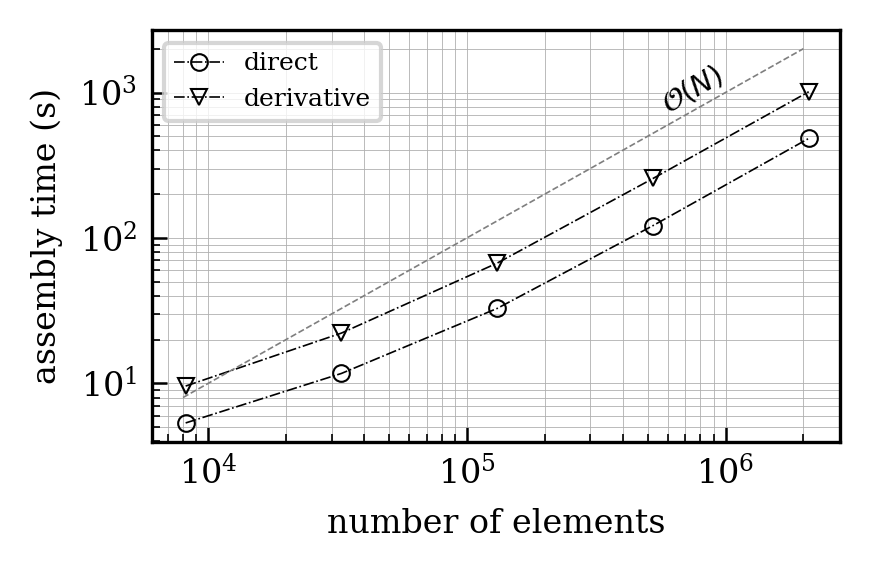

In [6]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)

ax.loglog(direct_df.index, direct_df.t_total_assembly, ls='dashdot', marker='o', fillstyle='none', label='direct', color='black')
ax.loglog(derivative_df.index, derivative_df.t_total_assembly, ls='dashdot', marker='v', fillstyle='none', label='derivative', color='black')

_x = [0.8*1e4, 2e6]
_y = 100 * np.array((0.08, 20))
ax.plot(_x, _y, color='#7f7f7f', linestyle='--')
text_loc = np.array((_x[1], _y[1]*1.2)) * 0.3
ax.text(text_loc[0], text_loc[1],r'$\mathcal{O}(N)$', fontsize=7, rotation=30,rotation_mode='anchor');

ax.set_xlabel('number of elements')
ax.set_ylabel('assembly time (s)')
ax.legend()
ax.grid(which='both')

plt.tight_layout()
# plt.savefig('../../tex/figs/sphere_assembly_time.pdf', dpi=300);

Next, we want to confirm that the time complexity of our FMM is also $\mathcal{O}(N)$.
We averaged the time spent on $1$ Laplace FMM and $1$ modified Helmholtz FMM respectively using direct formulation across all iterations, and plotted them with respect to $N$ in the figure below.

#### Figure: The average time of 1 Laplace FMM evaluation and 1 modified Helmholtz evaluation in GMRES with respect to problem size N using direct formulation.

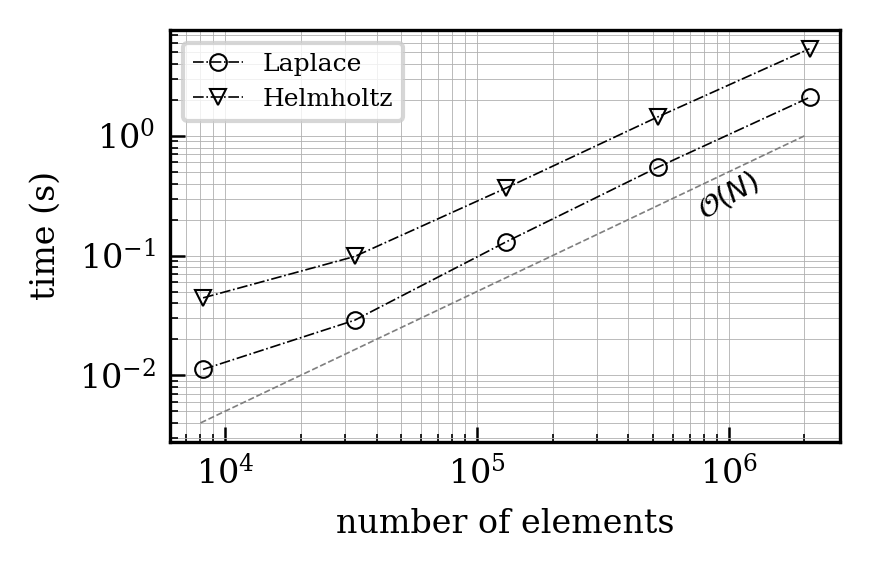

In [7]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)

ax.loglog(direct_df.index, direct_df.t_avg_laplace, ls='dashdot', marker='o', fillstyle='none', label='Laplace', color='black')
ax.loglog(direct_df.index, direct_df.t_avg_helmholtz, ls='dashdot', marker='v', fillstyle='none', label='Helmholtz', color='black')

_x = [0.8*1e4, 2e6]
_y = 0.05 * np.array((0.08, 20))
ax.legend()
ax.plot(_x, _y, color='#7f7f7f', linestyle='--')
text_loc = np.array((_x[1], _y[1]*0.5)) * 0.4
ax.text(text_loc[0], text_loc[1],r'$\mathcal{O}(N)$', fontsize=7, rotation=30,rotation_mode='anchor');
ax.grid(which='both')
ax.set_xlabel('number of elements')
ax.set_ylabel('time (s)')

plt.tight_layout()
# plt.savefig('../../tex/figs/sphere_fmm.pdf', dpi=300);

The two figures below show the time breakdown of our GMRES, consisting of FMM time, singular correction time, and the time spent on other operations in GMRES. 

#### Figure: Time breakdown of GMRES in percentage using the direct and derivative formulation.

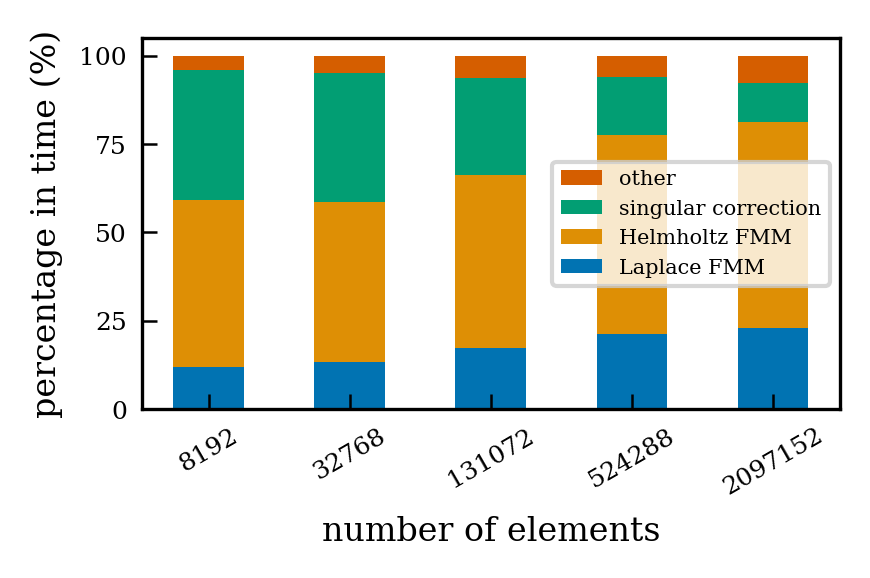

In [8]:
prop_laplace = direct_df.t_laplace / direct_df.t_total_gmres * 100
prop_helmholtz = direct_df.t_helmholtz / direct_df.t_total_gmres * 100
prop_correction = direct_df.t_singular_correction / direct_df.t_total_gmres * 100
prop_other = direct_df.t_gmres_other / direct_df.t_total_gmres * 100

width = 0.5
r = np.arange(direct_df.shape[0])
fig = plt.figure(figsize=(3,2))
ax1 = fig.add_subplot(111)
ax1.set_prop_cycle(cb)
ax1.bar(r, prop_laplace, width=width, label='Laplace FMM')
ax1.bar(r, prop_helmholtz, bottom=prop_laplace, width=width, label='Helmholtz FMM')
ax1.bar(r, prop_correction, bottom=prop_laplace+prop_helmholtz, width=width, label='singular correction')
ax1.bar(r, prop_other, bottom=prop_laplace+prop_helmholtz+prop_correction, width=width, label='other')

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc='best', fontsize=5)
ax1.set_xlabel('number of elements')
ax1.set_ylabel('percentage in time (%)')

plt.yticks(fontsize=6)
plt.xticks(r, direct_df.index, rotation=30, fontsize=6)
plt.tight_layout()
# plt.savefig('../../tex/figs/sphere_gmres_direct.pdf', dpi=300);

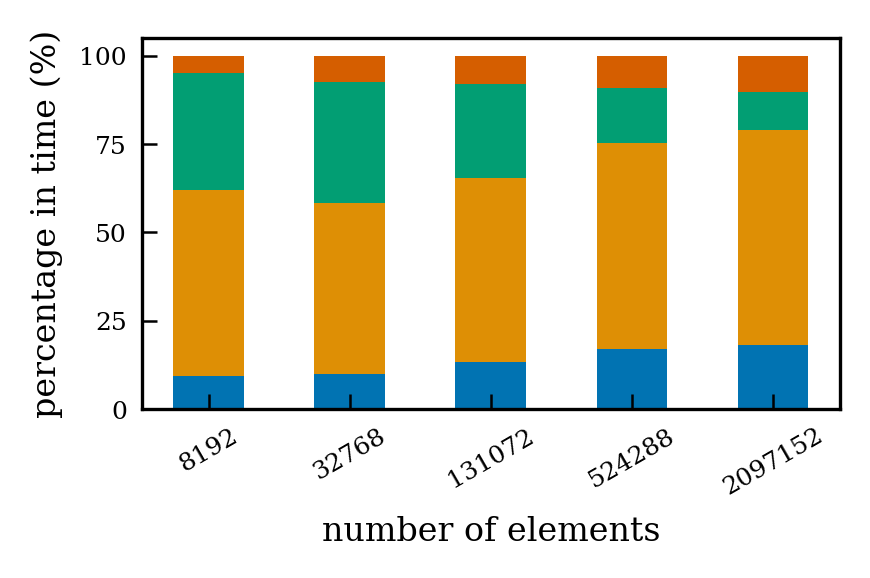

In [9]:
prop_laplace = derivative_df.t_laplace / derivative_df.t_total_gmres * 100
prop_helmholtz = derivative_df.t_helmholtz / derivative_df.t_total_gmres * 100
prop_correction = derivative_df.t_singular_correction / derivative_df.t_total_gmres * 100
prop_other = derivative_df.t_gmres_other / derivative_df.t_total_gmres * 100

fig = plt.figure(figsize=(3,2))
ax2 = fig.add_subplot(111)
ax2.set_prop_cycle(cb)
ax2.bar(r, prop_laplace, width=width, label='Laplace')
ax2.bar(r, prop_helmholtz, bottom=prop_laplace, width=width, label='Helmholtz')
ax2.bar(r, prop_correction, bottom=prop_laplace+prop_helmholtz, width=width, label='singular correction')
ax2.bar(r, prop_other, bottom=prop_laplace+prop_helmholtz+prop_correction, width=width, label='other')

ax2.set_xlabel('number of elements')
ax2.set_ylabel('percentage in time (%)')

plt.yticks(fontsize=6)
plt.xticks(r, direct_df.index, rotation=30, fontsize=6)

plt.tight_layout()
# plt.savefig('../../tex/figs/sphere_gmres_derivative.pdf', dpi=300);

We measured the peak memory usage of the simulations, using the Linux command `/usr/bin/time -v`.
The figure below demonstrates a linear space complexity of our solver.

#### Figure: Overall memory consumption in GB for both the direct and derivative formulation.

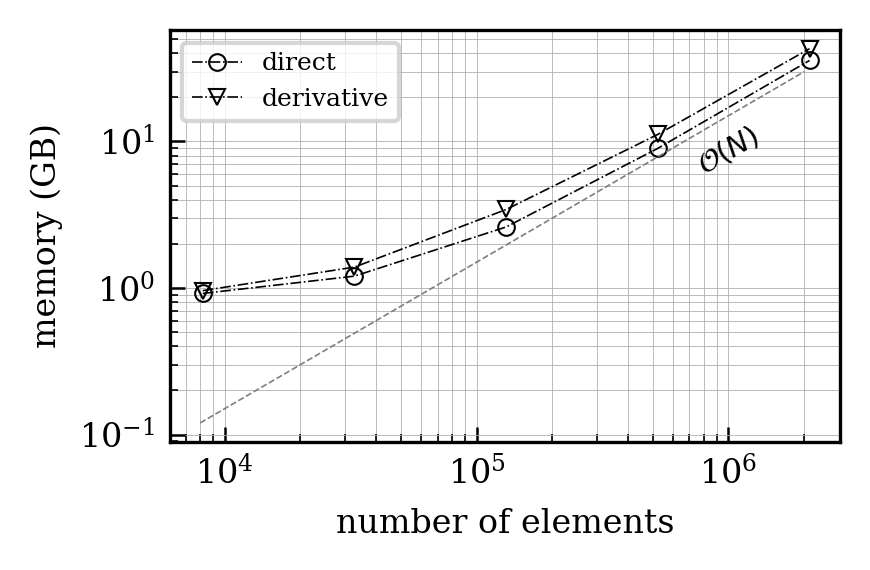

In [10]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)

ax.loglog(direct_df.index, direct_df['memory [GB]'], ls='dashdot', marker='o', fillstyle='none', label='direct', color='black')
ax.loglog(derivative_df.index, derivative_df['memory [GB]'], ls='dashdot', marker='v', fillstyle='none', label='derivative', color='black')
ax.grid(which='both')
_x = [0.8*1e4, 2e6]
_y = 1.5 * np.array((0.08, 20))
ax.legend(fontsize=6)
ax.plot(_x, _y, color='#7f7f7f', linestyle='--')
text_loc = np.array((_x[1], _y[1]*0.5)) * 0.4
ax.text(text_loc[0], text_loc[1],r'$\mathcal{O}(N)$', fontsize=7, rotation=30,rotation_mode='anchor');
ax.set_xlabel('number of elements')
ax.set_ylabel('memory (GB)')

plt.tight_layout()
# plt.savefig('../../tex/figs/sphere_memory.pdf', dpi=300);